In [1]:
#!pip install split-folders

In [2]:
import os
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import splitfolders
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
input_folder = '/home/nouman/Downloads/Kurdish_Handwritten/Kurdish_Data'
base_dir='/home/nouman/Downloads/Kurdish_Database'
os.makedirs(base_dir,exist_ok=True)
# Split with a ratio.
# To only split into training and validation set, we set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=base_dir, ratio=(.8, .2), group_prefix=None)

Copying files: 40861 files [00:28, 1439.41 files/s]


In [5]:
#directory which contains our data
#train_dir='/content/drive/MyDrive/Kurdish_Database/train'
#directory for training data
train_dir = os.path.join(base_dir, 'train')
#directory for testing data
test_dir = os.path.join(base_dir, 'val')
#datagenerator for training and validation data
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)#20% of training data is used for validation
#training data
train_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    subset='training')
#validation data
validation_generator = datagen.flow_from_directory(train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        subset='validation')

Found 26134 images belonging to 35 classes.
Found 6515 images belonging to 35 classes.


In [6]:
#datagenerator for testing data
test_datagen = ImageDataGenerator(rescale=1./255)
#test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=64,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 8177 images belonging to 35 classes.


In [7]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224, 3))
conv_base.trainable = False

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(35, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 35)                8995      
Total params: 21,146,467
Trainable params: 6,431,779
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-4),
              metrics=['acc'])
history = model.fit(train_generator,
                              batch_size=64,
                              epochs=6,
                              validation_data=validation_generator)
model.save('/home/nouman/Downloads/Kurdish_Handwritten/Kurdish_Data/model.h5')

Epoch 1/6
409/409 [==============================] - 7860s 19s/step - loss: 2.1460 - acc: 0.4679 - val_loss: 1.0410 - val_acc: 0.7104
Epoch 2/6
409/409 [==============================] - 7965s 19s/step - loss: 0.5587 - acc: 0.8511 - val_loss: 0.8527 - val_acc: 0.7524
Epoch 3/6
409/409 [==============================] - 7958s 19s/step - loss: 0.3457 - acc: 0.9055 - val_loss: 0.7104 - val_acc: 0.7985
Epoch 4/6
409/409 [==============================] - 7878s 19s/step - loss: 0.2524 - acc: 0.9287 - val_loss: 0.7243 - val_acc: 0.7955
Epoch 5/6
409/409 [==============================] - 8743s 21s/step - loss: 0.1966 - acc: 0.9466 - val_loss: 0.6978 - val_acc: 0.8112
Epoch 6/6
409/409 [==============================] - 7935s 19s/step - loss: 0.1585 - acc: 0.9571 - val_loss: 0.6407 - val_acc: 0.8184


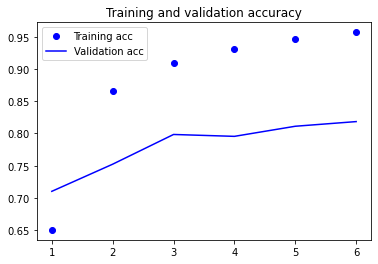

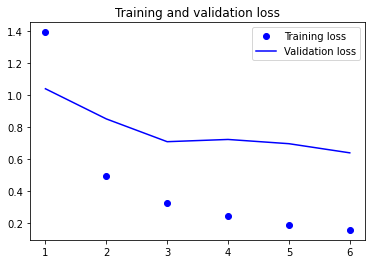

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<AxesSubplot:>

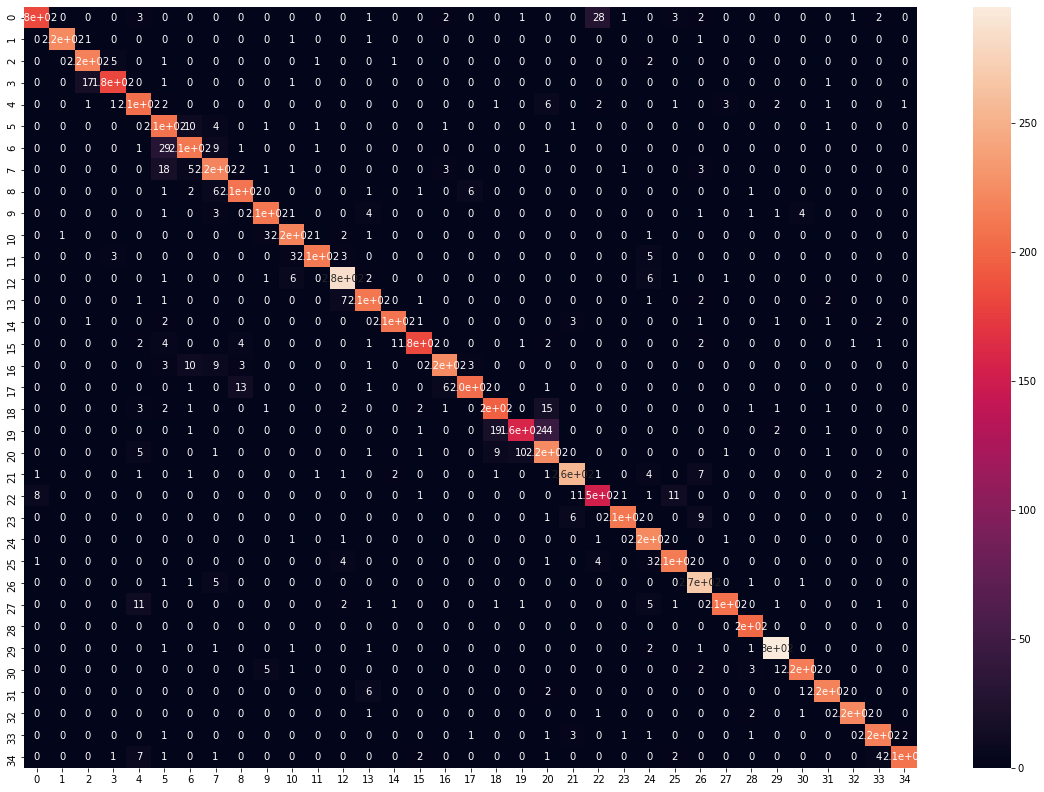

In [11]:
#predicting the model for validation data
y_pred= model.predict(test_generator)
#testing labels
y_true= test_generator.classes
#finding confusion matrix for validation data
cnf_matrix= confusion_matrix(y_true,y_pred.argmax(axis=1))
#print('Confusion Matrix:\n',cnf_matrix)
#generating heat map for confusion matrix
plt.figure(figsize = (20,14))
sns.heatmap(cnf_matrix, annot=True)